In [3]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as co
from SAGAbg import line_fitting, SAGA_get_spectra


import sys
sys.path.append('../scripts/')
import linesearch
import catalogs
import logistics

In [10]:
clean = catalogs.build_saga_catalog ().to_pandas ()

SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:347: RuntimeWarning: divide by zero encountered in true_divide
  self._T_hypergeometric(s / (z2 + 1.0)))
/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)


In [14]:
dropbox_dir = '/Users/kadofong/Dropbox/SAGA/'
tdict = logistics.load_filters ()

In [173]:
name = 'career_commemorates' 
obj = clean.loc[name]

/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/modeling/functional_models.py:180: RuntimeWarning: divide by zero encountered in true_divide
  return amplitude * np.exp(- 0.5 * (x - mean) ** 2 / stddev ** 2)


[u_flux] 4 sec elapsed; 0.09 avg. laptime


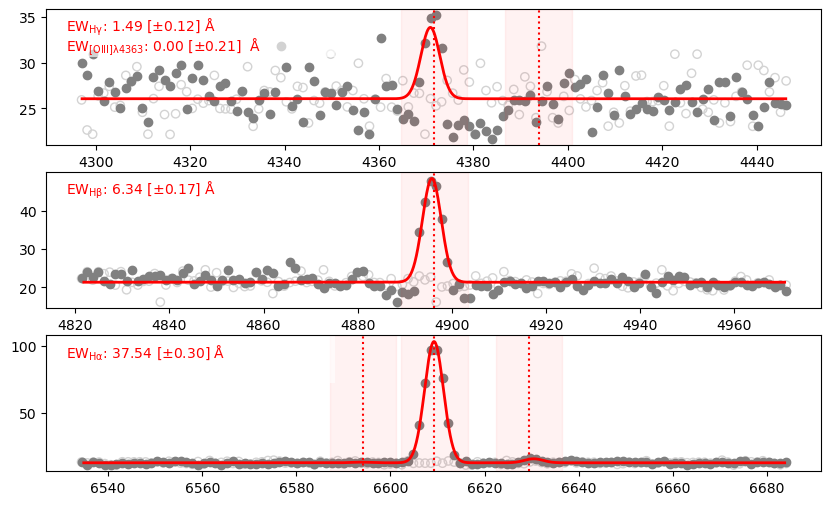

In [176]:
out = do_measurehalpha.dowork ( obj, tdict, '/Users/kadofong/Dropbox/SAGA/', True )
(Lha_direct, u_Lha_direct), (Lha_ew, u_Lha_ew), ls_output = out

(-2.0, 81.89736909484904)

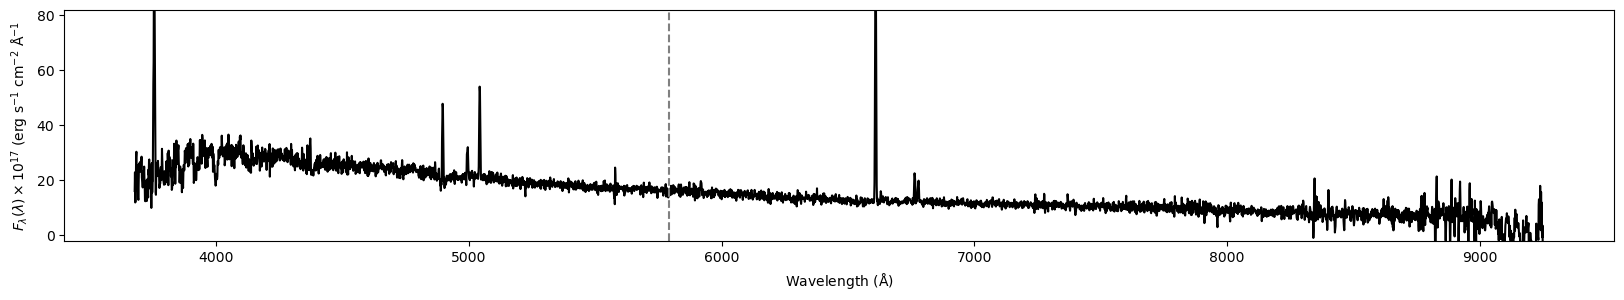

In [177]:
fig, axarr = plt.subplots(1,1,figsize=(20,3))

plt.plot ( wave, fluxcal , color='k' )
plt.axvline ( 5790, color='grey', ls='--' )
plt.xlabel(r'Wavelength ($\rm \AA$)')
plt.ylabel(r'$F_\lambda (\lambda) \times 10^{17}$ (erg s$^{-1}$ cm$^{-2}$ $\rm \AA^{-1}$')
plt.ylim(-2.,np.nanquantile(flux*1e17*qfactors.mean(),.999))


# Compare singleton output

In [27]:
import glob
from astropy import table
from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [5]:
# \\ load comparison samples
import pandas as pd
from astropy.io import fits
from astropy.io import ascii as astro_ascii

shioya = np.genfromtxt('../../literature_ref/shioya2009/shioya_fig9.csv', delimiter=',')
sdss_smass = pd.DataFrame(fits.getdata('../../sdss/local_data/sdssJHU/totlgm_dr7_v5_2.fit.gz', 1)).replace(-1, np.nan)
sdss_sfr = pd.DataFrame(fits.getdata(  '../../sdss/local_data/sdssJHU/gal_totsfr_dr7_v5_2.fits.gz', 1)).replace(-99, np.nan)

leroy = astro_ascii.read ( '../../literature_ref/leroy2008/table4.dat',
                    readme='../../literature_ref/leroy2008/ReadMe').to_pandas()


In [74]:
gama_magphys = table.Table(fits.getdata('../../gama/local_data/MagPhysv06.fits' ,1 )).to_pandas ()
gama_magphys = gama_magphys.set_index('CATAID')
gamasfrkey = 'SFR_0_1Gyr_percentile50'
gama_magphys = gama_magphys.loc[gama_magphys[gamasfrkey]>-7]


gama_smass = table.Table(fits.getdata('../../gama/local_data/StellarMassesLambdarv20.fits' ,1 )).to_pandas ()
qcut = gama_smass['nQ']>2
qcut &= gama_smass['absmag_r'] < -10
qcut &= gama_smass['Z'] > 0.001
qcut &= gama_smass['Z'] < 0.5
qcut &= gama_smass['absmag_r'] > -99
gama_smass = gama_smass.loc[qcut].set_index("CATAID")

In [6]:
lumha2sfr = lambda lum: 5.5e-42 * lum#.to(u.erg/u.s).value

In [7]:
fluxes = glob.glob('../local_data/line_fits/*/*fluxes.dat')
names = np.array([ x.split('/')[-2] for x in fluxes ])
models = [ x.replace('_fluxes','_lineparams') for x in fluxes ]
ufcs = [ x.replace('_fluxes','_ucontinuum') for x in fluxes ]
lumhas = [ x.replace('_fluxes','_haluminosity') for x in fluxes ]
print(f'{len(names)} galaxies processed.')

4319 galaxies processed.


In [8]:
halum_arr = np.zeros([len(names), 2,2])
for idx,name in enumerate(lumhas):
    halum_arr[idx] = np.genfromtxt(name)

In [76]:
np.genfromtxt(name)

array([[7.45799712e+39, 7.35703348e+39],
       [6.50581664e+38, 7.65271246e+38]])

In [69]:
color_dict = {'SAGA':'#944abd', 'SAGAbg':'#f6315a'}

In [120]:
def binned_mean ( x, y, bins ):
    assns = np.digitize ( x, bins )
    midpts = 0.5*(bins[1:]+bins[:-1])
    arr = np.zeros([len(midpts),2])
    for idx in range(1, len(bins)):
        mask = np.isfinite(y)
        arr[idx-1,0] = np.nanmean(y[(assns==idx)&mask])
        arr[idx-1,1] = np.nanstd(y[(assns==idx)&mask])
    return midpts, arr

In [100]:
mbins = np.arange(-19, -10,2.)

In [101]:
mbins

array([-19., -17., -15., -13., -11.])

In [121]:
mask = (clean.reindex(names)['oc_Mr']>-19)&(clean.reindex(names)['oc_Mr']<-17)
np.nanmedian(np.log10(lumha2sfr(Lha_direct))[mask&np.isfinite(np.log10(lumha2sfr(Lha_direct)))])

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/375452636.py:2: RuntimeWarning: divide by zero encountered in log10
  np.nanmedian(np.log10(lumha2sfr(Lha_direct))[mask&np.isfinite(np.log10(lumha2sfr(Lha_direct)))])
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/375452636.py:2: RuntimeWarning: invalid value encountered in log10
  np.nanmedian(np.log10(lumha2sfr(Lha_direct))[mask&np.isfinite(np.log10(lumha2sfr(Lha_direct)))])


-1.3055727387723715

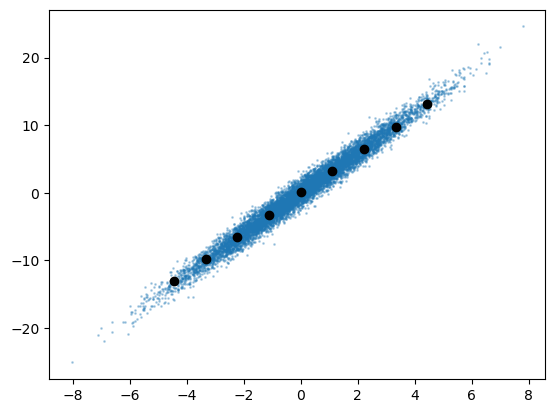

In [122]:
N = int(1e4)
x = np.random.normal(0., 2., N)
y = 3.*x + np.random.normal ( 0., 1., N)
plt.scatter ( x, y, alpha=0.3, s=1)
mbins = np.linspace(-5,5,10)
midpts, arr = binned_mean ( x,y, mbins)
plt.plot ( midpts, arr[:,0], 'o', color='k' )

In [143]:
from scipy import ndimage

In [ ]:
plt.contour(

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/2526909652.py:6: RuntimeWarning: divide by zero encountered in log10
  axarr[0].scatter ( clean.reindex(names)['oc_Mr'], np.log10(Lha_ew), s=1, color='r')
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/2526909652.py:11: RuntimeWarning: divide by zero encountered in log10
  axarr[0].scatter ( clean.reindex(names)['oc_Mr'], np.log10(Lha_direct), s=1, c=color_dict['SAGAbg'] )
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/2526909652.py:11: RuntimeWarning: invalid value encountered in log10
  axarr[0].scatter ( clean.reindex(names)['oc_Mr'], np.log10(Lha_direct), s=1, c=color_dict['SAGAbg'] )
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/2526909652.py:33: RuntimeWarning: divide by zero encountered in log10
  ax.scatter ( clean.reindex(names)['oc_Mr'], np.log10(lumha2sfr(Lha_direct)),s=1,
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_811/2526909652.py:33: RuntimeWarni

Text(0, 0.5, 'SFR (M$_\\odot$ yr$^{-1}$)')

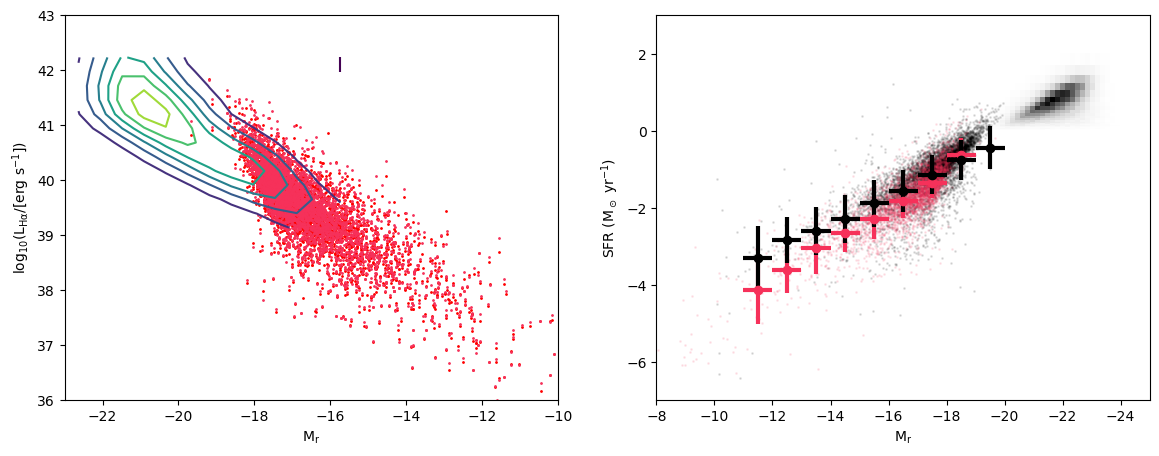

In [150]:
fig, axarr = plt.subplots(1,2,figsize=(14,5))
#axarr[0].scatter ( shioya[:,0], shioya[:,1], color='k', s=5, zorder=10)
Lha_ew = halum_arr[:,0,0]
Lha_direct = halum_arr[:,0,1]

axarr[0].scatter ( clean.reindex(names)['oc_Mr'], np.log10(Lha_ew), s=1, color='r')
counts, xbins, ybins = np.histogram2d(shioya[:,0], shioya[:,1], bins=13)
counts = ndimage.gaussian_filter ( counts, 1)
mid = lambda x: 0.5*(x[1:]+x[:-1])
axarr[0].contour ( mid(xbins), mid(ybins), counts )
axarr[0].scatter ( clean.reindex(names)['oc_Mr'], np.log10(Lha_direct), s=1, c=color_dict['SAGAbg'] )
axarr[0].set_xlim(-23,-10)
axarr[0].set_ylim(36,43)

ax = axarr[1]
#ax.hist2d ( sdss_smass['MEDIAN'], 10.**sdss_sfr['MEDIAN'], bins=[np.linspace(7.,10.5,100), 
#                                                                 10.**np.linspace(-5,2,100)], cmap='Greys')
#lmask = sdss_smass['MEDIAN'] < 9.
#ax.scatter ( sdss_smass['MEDIAN'][lmask], 10.**sdss_sfr['MEDIAN'][lmask], s=1, color='k', alpha=0.05 )
#ax.scatter ( leroy['logM*'], leroy['SFR'], facecolor='None', edgecolor='b', marker='s', zorder=10) 
gintersection = gama_smass.index.intersection(gama_magphys.index)

#ax.scatter ( gama_smass.reindex(gintersection)['absmag_r'], 
#             10.**gama_magphys.reindex(gintersection)[gamasfrkey], s=1, alpha=0.05, color='k', )
bins = [np.linspace(-25, -8,100), 10.**np.linspace(-5,2,100)]
ax.hist2d ( gama_smass.reindex(gintersection)['absmag_r'], gama_magphys.reindex(gintersection)[gamasfrkey],
            bins=bins, cmap='Greys')

lowmass = gama_smass.reindex(gintersection)['logmstar'] < 9.
ax.scatter ( gama_smass.reindex(gintersection).loc[lowmass, 'absmag_r'], 
            gama_magphys.reindex(gintersection).loc[lowmass, gamasfrkey],
             s=1, color='k', alpha=0.1)
ax.scatter ( clean.reindex(names)['oc_Mr'], np.log10(lumha2sfr(Lha_direct)),s=1, 
            color=color_dict['SAGAbg'], alpha=0.1)


# \\ binned mean, SAGA
mbins = np.arange(-19, -10,1.)
midpts, arr = binned_mean ( clean.reindex(names)['oc_Mr'], np.log10(lumha2sfr(Lha_direct)), bins=mbins)
plt.errorbar ( midpts, arr[:,0], xerr=np.diff(mbins)/2., yerr=arr[:,1], fmt='o',  
              color=color_dict['SAGAbg'], lw=3)

## \\ binned mean, GAMA
mbins = np.arange(-20, -10,1.)
midpts, arr = binned_mean ( gama_smass.reindex(gintersection)['absmag_r'], 
                            gama_magphys.reindex(gintersection)[gamasfrkey], bins=mbins)
plt.errorbar ( midpts, arr[:,0], xerr=np.diff(mbins)/2., yerr=arr[:,1], fmt='o',  color='k', lw=3)

#ax.set_yscale('log')
ax.set_xlim(-8, -25)
ax.set_ylim(-7,3)

axarr[0].set_xlabel(r'M$_{\rm r}$' )
axarr[0].set_ylabel(r'$\log_{10}(\rm L_{H\alpha} / [erg\ s^{-1}])$')
axarr[1].set_xlabel(axarr[0].get_xlabel())
axarr[1].set_ylabel(r'SFR (M$_\odot$ yr$^{-1}$)')